1. Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os  

In [2]:
import cv2
import imghdr

2. GPU Configuration for Tensorflow


In [3]:
gpus=tf.config.experimental.list_physical_devices("GPU")
gpus
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

3. Data Preprocessing

In [4]:
data_dir="data"
image_exts=["jpeg","jpg","bmp","png"]

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path =os.path.join(data_dir,image_class,image)
        try:
            img=cv2.imread(image_path)
            tip=imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list{}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))
            os.remove(image_path)

4. Maping the data

In [7]:
data=tf.keras.utils.image_dataset_from_directory("data")
data=data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()



Found 582 files belonging to 2 classes.


In [9]:
batch=scaled_iterator.next()
batch[1]

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [10]:
batch[0].max()

1.0

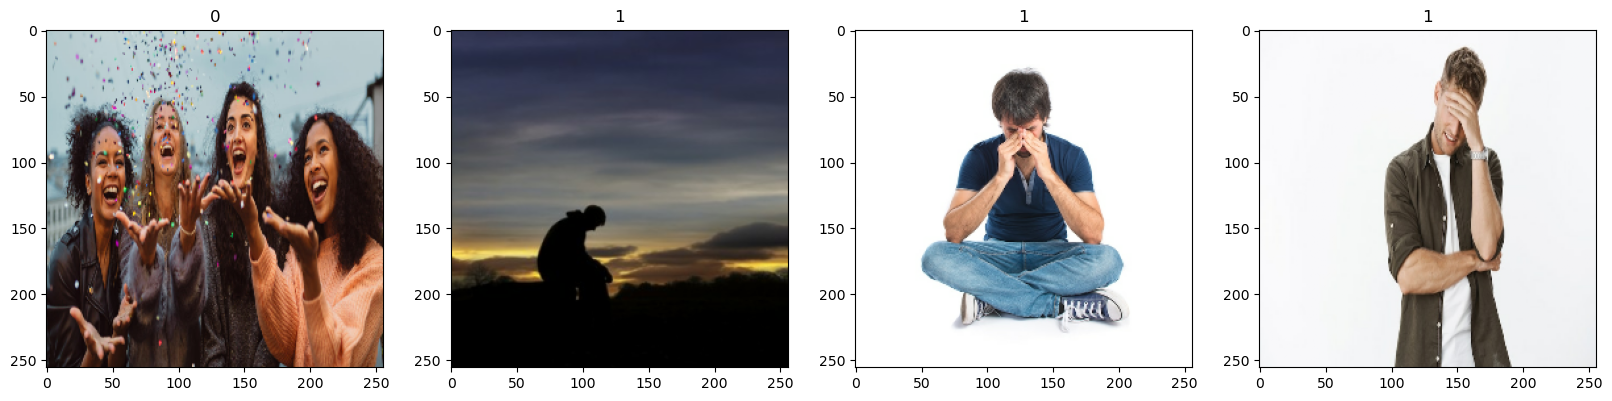

In [11]:
#HAPPY PPL = 0
#SAD PPL = 1
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [12]:
len(data)
train_size=(int)(len(data)*.7)
val_size=(int)(len(data)*.2)
test_size=(int)(len(data)*.1)+1

In [13]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

5. Deep learning Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [17]:
model.compile('adam', loss=tf.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

6. Train

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

NameError: name 'logdir' is not defined

In [22]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

NameError: name 'tensorboard_callback' is not defined

In [26]:
hist.history

{'loss': [0.38212427496910095,
  0.1536041647195816,
  0.12791825830936432,
  0.08479178696870804,
  0.056452009826898575,
  0.031807705760002136,
  0.023416833952069283,
  0.009948373772203922,
  0.008916781283915043,
  0.006851826794445515,
  0.003496540477499366,
  0.0016802381724119186,
  0.001122453366406262,
  0.0017089766915887594,
  0.001114472048357129,
  0.0009304802515543997,
  0.0004172896151430905,
  0.00034632079768925905,
  0.00016481841157656163,
  0.00010307971388101578],
 'accuracy': [0.48076921701431274,
  0.6802884340286255,
  0.7932692170143127,
  0.879807710647583,
  0.9543269276618958,
  0.973557710647583,
  0.9759615659713745,
  1.0,
  0.9903846383094788,
  1.0,
  0.995192289352417,
  1.0,
  1.0,
  0.9975961446762085,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.16716547310352325,
  0.13334809243679047,
  0.10421627759933472,
  0.08542916178703308,
  0.06065210700035095,
  0.05761739984154701,
  0.014130321331322193,
  0.009042457677423954,
  0.010

7. Plotting the result

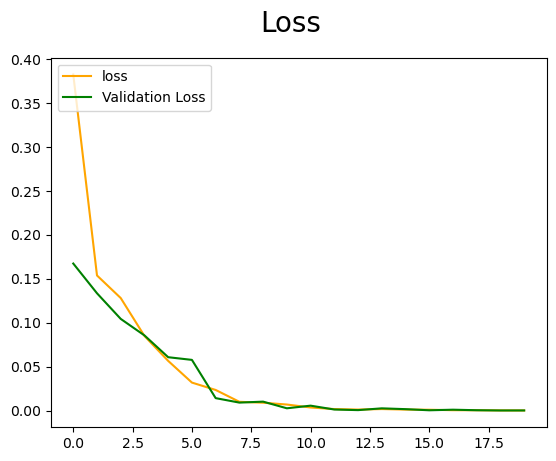

In [27]:
fig=plt.figure()
plt.plot(hist.history["loss"], color= "orange", label="loss")
plt.plot(hist.history["val_loss"], color="green",label="Validation Loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

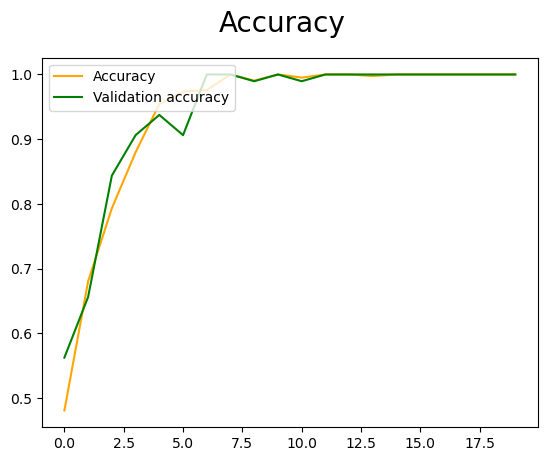

In [28]:
fig=plt.figure()
plt.plot(hist.history["accuracy"], color= "orange",label="Accuracy")
plt.plot(hist.history["val_accuracy"], color="green",label="Validation accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

8. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [31]:
len(test)

2

In [36]:
for batch in test.as_numpy_iterator():
    x,y=batch
    pred=model.predict(x)
    pre.update_state(y,pred)
    re.update_state(y,pred)
    acc.update_state(y,pred)

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: data\Sad\father-and-son.jpg : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

In [37]:
print("Precision:", pre.result().numpy(),"Recall:", re.result().numpy(),"Accuracy:", acc.result().numpy())

Precision: 0.0 Recall: 0.0 Accuracy: 0.0


9. Testing

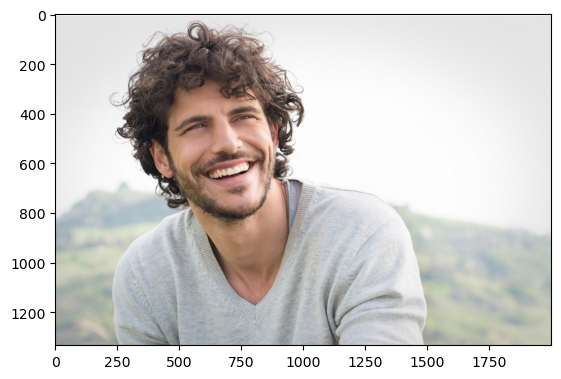

In [39]:
img=cv2.imread("happytest.jpeg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

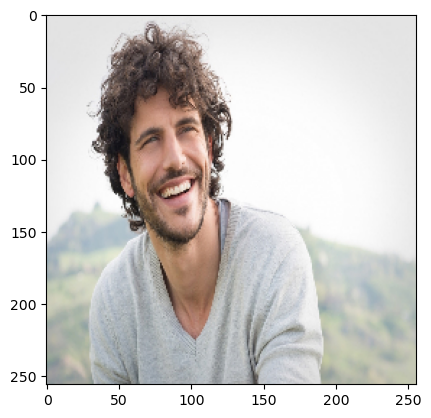

In [40]:
resize=tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
pred=model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 595ms/step


In [42]:
pred

array([[0.17942941]], dtype=float32)

In [43]:
if(pred>.5):
    print("Prediciton is Sad")
else:
    print("Prediction is Happy")

Prediction is Happy


10. Saving The model

In [44]:
from tensorflow.keras.models import load_model
model.save(os.path.join("model","sentimentpredictionmodel.h5"))

11.Implementing the saved model

In [23]:
import cv2;
import numpy as np;
from matplotlib import pyplot as plt;
import tensorflow as tf;
import os;


In [24]:
from tensorflow.keras.models import load_model
new_model=load_model(os.path.join("model","sentimentpredictionmodel.h5"))

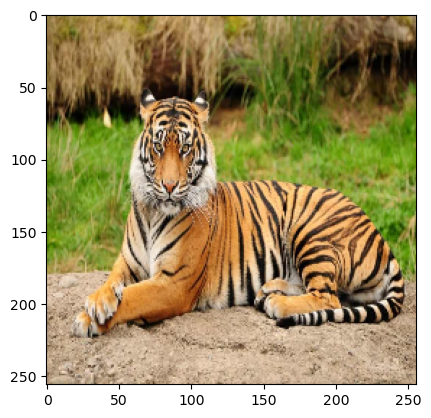

In [33]:

img=cv2.imread("animal.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_resize=tf.image.resize(img,(256,256))
plt.imshow(img_resize.numpy().astype(int))
plt.show()

In [34]:
pred2=new_model.predict(np.expand_dims(img_resize/255,0))

1/1 [==============================] - 0s 28ms/step


In [35]:
if(pred2<.5):
    print("Prediciton is Happy")
else:
    print("Prediction is Sad")

Prediciton is Happy
